In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm

# Set up visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [5]:
# Load the data
df = pd.read_csv('../data/raw/complaints.csv')

C:\Users\fre\AppData\Local\Temp\ipykernel_19740\3078984525.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/raw/complaints.csv')


In [6]:
# Basic info
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
display(df.head())

Dataset shape: (9609797, 18)

First few rows:


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692


In [7]:
# Check column names and data types
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9609797 entries, 0 to 9609796
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 1.3+

In [8]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

Missing values per column:
Sub-product                      235295
Issue                                 6
Sub-issue                        839522
Consumer complaint narrative    6629041
Company public response         4770207
State                             54516
ZIP code                          30228
Tags                            8981029
Consumer consent provided?      1649561
Company response to consumer         20
Consumer disputed?              8841498
dtype: int64


In [9]:
# Filter to only the 5 products we care about
target_products = [
    'Credit card', 
    'Personal loan', 
    'Buy Now, Pay Later (BNPL)', 
    'Savings account', 
    'Money transfers'
]

In [10]:
# Filter the dataframe
product_df = df[df['Product'].isin(target_products)].copy()

C:\Users\fre\AppData\Local\Temp\ipykernel_19740\2490260593.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_counts.index, y=product_counts.values, palette="viridis")


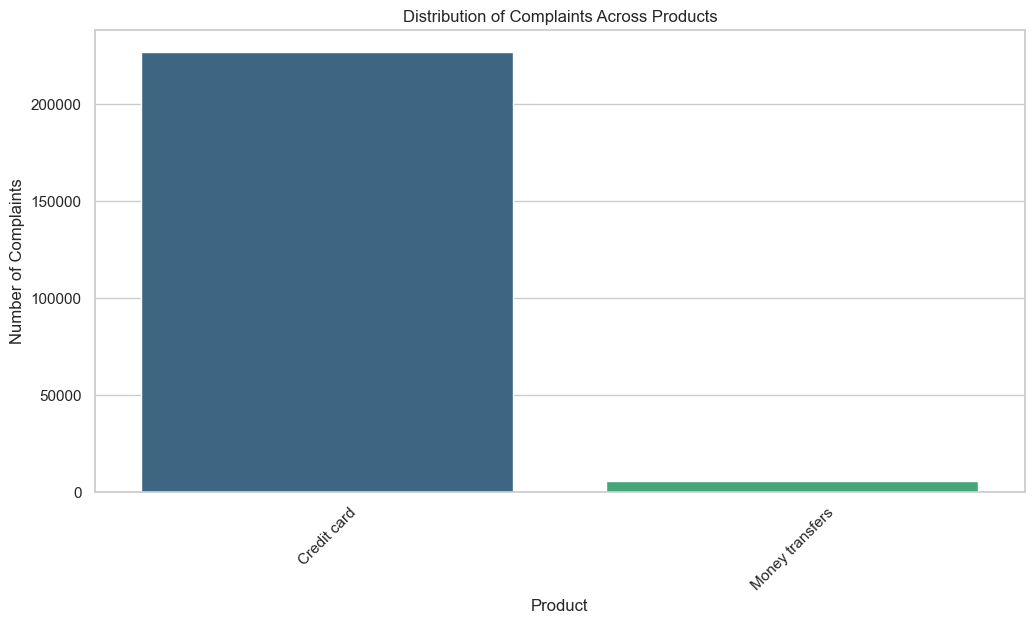

In [11]:
# Plot complaint distribution by product
plt.figure(figsize=(12, 6))
product_counts = product_df['Product'].value_counts()
sns.barplot(x=product_counts.index, y=product_counts.values, palette="viridis")
plt.title('Distribution of Complaints Across Products')
plt.xlabel('Product')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45)
plt.show()

In [12]:
# Check for empty narratives
empty_narratives = product_df['Consumer complaint narrative'].isnull().sum()
print(f"Number of complaints without narratives: {empty_narratives}")
print(f"Percentage: {empty_narratives/len(product_df)*100:.2f}%")

Number of complaints without narratives: 149876
Percentage: 64.59%


In [13]:
# Filter out rows without narratives
narrative_df = product_df[product_df['Consumer complaint narrative'].notna()].copy()
print(f"Dataset shape after removing empty narratives: {narrative_df.shape}")


Dataset shape after removing empty narratives: (82164, 18)


In [14]:
# Calculate narrative lengths
narrative_df['narrative_length'] = narrative_df['Consumer complaint narrative'].apply(lambda x: len(x.split()))

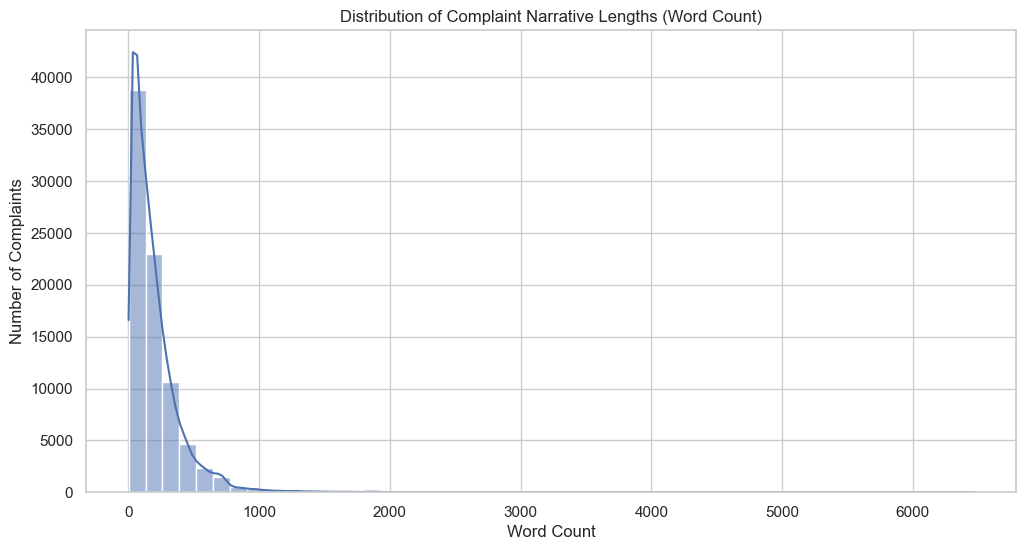

In [15]:
# Plot distribution of narrative lengths
plt.figure(figsize=(12, 6))
sns.histplot(narrative_df['narrative_length'], bins=50, kde=True)
plt.title('Distribution of Complaint Narrative Lengths (Word Count)')
plt.xlabel('Word Count')
plt.ylabel('Number of Complaints')
plt.show()

In [16]:
# Show some statistics
print("Narrative length statistics:")
print(narrative_df['narrative_length'].describe())

Narrative length statistics:
count    82164.000000
mean       200.050898
std        222.340380
min          2.000000
25%         63.000000
50%        142.000000
75%        260.000000
max       6469.000000
Name: narrative_length, dtype: float64


In [17]:
# ## Text Preprocessing
# First, let's verify the column we'll be processing
print("Columns in our filtered DataFrame:")
print(narrative_df.columns.tolist())

Columns in our filtered DataFrame:
['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID', 'narrative_length']


In [18]:
# Check the first few narratives to understand the content
print("\nSample narratives before cleaning:")
for i in range(3):
    print(f"\n--- Narrative {i+1} ---")
    print(narrative_df['Consumer complaint narrative'].iloc[i][:300] + "...")  # Show first 300 chars


Sample narratives before cleaning:

--- Narrative 1 ---
A XXXX XXXX card was opened under my name by a fraudster. I received a notice from XXXX  that an account was just opened under my name. I reached out to XXXX XXXX to state that this activity was unauthorized and not me. XXXX XXXX confirmed this was fraudulent and immediately closed the card. However...

--- Narrative 2 ---
Dear CFPB, I have a secured credit card with citibank which is changed to unsecured card and I have been calling n waitting for the check release the secured amount {$2500.00} for rhat credit card. They told me to wait then today they told me someone cashed my check but their system doesnt have info...

--- Narrative 3 ---
I have a Citi rewards cards. The credit balance issued to me was {$8400.00}. I recently moved, which meant my bills would be lowered, which meant I'd have LESS use for my credit cards. So in order to keep my usage in a generally good area I used each of my cards with the intention to pay them

In [19]:
def clean_text(text):
    """
    Clean and normalize complaint narrative text with robust handling for:
    - Missing values
    - Non-string values
    - Boilerplate text
    - Special characters
    - Extra whitespace
    """
    # Handle missing or non-string values
    if not isinstance(text, str):
        return ""
    
    # Lowercase all text
    text = text.lower()
    
    # Remove common complaint boilerplate (case insensitive)
    boilerplate_phrases = [
        r'i am writing to file a complaint',
        r'i am writing to complain about',
        r'this is a complaint regarding',
        r'this is a complaint about',
        r'this is a formal complaint',
        r'dear consumer financial protection bureau',
        r'to whom it may concern',
        r'please be advised that',
        r'i am contacting you regarding',
        r'this letter is to inform you that'
    ]
    
    for phrase in boilerplate_phrases:
        text = re.sub(phrase, '', text, flags=re.IGNORECASE)
    
    # Remove specific patterns like dates (XX/XX/XXXX) and reference numbers
    text = re.sub(r'\d{1,2}/\d{1,2}/\d{2,4}', '', text)  # Dates
    text = re.sub(r'#\d+', '', text)  # Reference numbers like #12345
    text = re.sub(r'\b\d{10,}\b', '', text)  # Long numbers (account numbers)
    
    # Remove special characters but preserve basic punctuation
    text = re.sub(r'[^\w\s.,!?]', ' ', text)
    
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [20]:
# Apply cleaning with progress bar and validation
tqdm.pandas(desc="Cleaning narratives")
narrative_df['cleaned_narrative'] = narrative_df['Consumer complaint narrative'].progress_apply(clean_text)

Cleaning narratives: 100%|██████████| 82164/82164 [00:44<00:00, 1843.80it/s]


In [21]:
# Quality check - compare before/after cleaning
print("\nCleaning Quality Check:")
sample_indices = [0, 100, 500]  # Adjust based on your dataset size
for idx in sample_indices:
    print(f"\n--- Sample {idx} ---")
    print("\nOriginal:")
    print(narrative_df['Consumer complaint narrative'].iloc[idx][:500])
    print("\nCleaned:")
    print(narrative_df['cleaned_narrative'].iloc[idx][:500])
    print("\n" + "-"*50)


Cleaning Quality Check:

--- Sample 0 ---

Original:
A XXXX XXXX card was opened under my name by a fraudster. I received a notice from XXXX  that an account was just opened under my name. I reached out to XXXX XXXX to state that this activity was unauthorized and not me. XXXX XXXX confirmed this was fraudulent and immediately closed the card. However, they have failed to remove this from the three credit agencies and this fraud is now impacting my credit score based on a hard credit pull done by XXXX XXXX that was done by a fraudster.

Cleaned:
a xxxx xxxx card was opened under my name by a fraudster. i received a notice from xxxx that an account was just opened under my name. i reached out to xxxx xxxx to state that this activity was unauthorized and not me. xxxx xxxx confirmed this was fraudulent and immediately closed the card. however, they have failed to remove this from the three credit agencies and this fraud is now impacting my credit score based on a hard credit pull done by

In [22]:
# Check for empty narratives after cleaning
empty_after_cleaning = narrative_df['cleaned_narrative'].str.strip().eq('').sum()
print(f"\nNumber of empty narratives after cleaning: {empty_after_cleaning}")
if empty_after_cleaning > 0:
    print("Warning: Some narratives became empty after cleaning. Inspect these cases.")
    display(narrative_df[narrative_df['cleaned_narrative'].str.strip().eq('')].head())


Number of empty narratives after cleaning: 0


In [23]:
# ## Save Processed Data
# Select columns to keep in final output
columns_to_keep = [
    'Product',
    'Sub-product',
    'Issue',
    'Sub-issue',
    'Consumer complaint narrative',  # Original text
    'cleaned_narrative',            # Processed text
    'Company',
    'Company public response',
    'State',
    'ZIP code',
    'Date received',
    'Complaint ID'                  # Unique identifier
]

In [ ]:
# Create final DataFrame
final_df = narrative_df[columns_to_keep].copy()

In [25]:
# Verify final DataFrame structure
print("Final DataFrame columns:")
print(final_df.columns.tolist())
print("\nShape:", final_df.shape)

Final DataFrame columns:
['Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'cleaned_narrative', 'Company', 'Company public response', 'State', 'ZIP code', 'Date received', 'Complaint ID']

Shape: (82164, 12)


In [26]:
# Save to CSV
output_path = '../data/preprocessed/filtered_complaints.csv'
final_df.to_csv(output_path, index=False)
print(f"\nSaved processed data to {output_path}")
print(f"Total records saved: {len(final_df)}")


Saved processed data to ../data/preprocessed/filtered_complaints.csv
Total records saved: 82164


In [27]:
# Final check - load the saved data to verify
verify_df = pd.read_csv(output_path)
print("\nVerification - loaded data info:")
print(verify_df.info())


Verification - loaded data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82164 entries, 0 to 82163
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product                       82164 non-null  object
 1   Sub-product                   63327 non-null  object
 2   Issue                         82164 non-null  object
 3   Sub-issue                     61770 non-null  object
 4   Consumer complaint narrative  82164 non-null  object
 5   cleaned_narrative             82164 non-null  object
 6   Company                       82164 non-null  object
 7   Company public response       39566 non-null  object
 8   State                         81857 non-null  object
 9   ZIP code                      82164 non-null  object
 10  Date received                 82164 non-null  object
 11  Complaint ID                  82164 non-null  int64 
dtypes: int64(1), object(11)
memory usage: 7.